# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "learningRate_oracle.run2",
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "lr": 1e-05,
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.004635015
Average power, source: 2.8574976e-05


Average magnitude, target: 0.0029128897
Average power, target: 1.0910343e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 420], examples_per_second: 9.2499, train_label_loss: 2.7458, 


epoch: 1, [batch: 42 / 420], examples_per_second: 819.6335, train_label_loss: 2.4460, 


epoch: 1, [batch: 84 / 420], examples_per_second: 879.4502, train_label_loss: 1.9442, 


epoch: 1, [batch: 126 / 420], examples_per_second: 980.7971, train_label_loss: 1.7294, 


epoch: 1, [batch: 168 / 420], examples_per_second: 1094.1013, train_label_loss: 1.4585, 


epoch: 1, [batch: 210 / 420], examples_per_second: 1191.5577, train_label_loss: 1.4273, 


epoch: 1, [batch: 252 / 420], examples_per_second: 1456.4269, train_label_loss: 1.3712, 


epoch: 1, [batch: 294 / 420], examples_per_second: 1603.0921, train_label_loss: 1.2280, 


epoch: 1, [batch: 336 / 420], examples_per_second: 1792.9249, train_label_loss: 1.3169, 


epoch: 1, [batch: 378 / 420], examples_per_second: 2190.2636, train_label_loss: 1.4061, 


epoch: 1, source_val_acc_label: 0.4408, target_val_acc_label: 0.3621, source_val_label_loss: 1.7635, target_val_label_loss: 1.9929, 


New best


epoch: 2, [batch: 1 / 420], examples_per_second: 4.9192, train_label_loss: 2.0455, 


epoch: 2, [batch: 42 / 420], examples_per_second: 766.3762, train_label_loss: 1.7309, 


epoch: 2, [batch: 84 / 420], examples_per_second: 847.6046, train_label_loss: 1.3232, 


epoch: 2, [batch: 126 / 420], examples_per_second: 923.2549, train_label_loss: 1.2992, 


epoch: 2, [batch: 168 / 420], examples_per_second: 1019.4722, train_label_loss: 1.3642, 


epoch: 2, [batch: 210 / 420], examples_per_second: 1164.3634, train_label_loss: 1.3304, 


epoch: 2, [batch: 252 / 420], examples_per_second: 1294.6366, train_label_loss: 1.2078, 


epoch: 2, [batch: 294 / 420], examples_per_second: 1473.0502, train_label_loss: 1.3465, 


epoch: 2, [batch: 336 / 420], examples_per_second: 1761.8515, train_label_loss: 1.5539, 


epoch: 2, [batch: 378 / 420], examples_per_second: 2096.9005, train_label_loss: 1.3756, 


epoch: 2, source_val_acc_label: 0.4599, target_val_acc_label: 0.3779, source_val_label_loss: 1.2972, target_val_label_loss: 1.6412, 


New best


epoch: 3, [batch: 1 / 420], examples_per_second: 4.8661, train_label_loss: 1.3599, 


epoch: 3, [batch: 42 / 420], examples_per_second: 751.6354, train_label_loss: 1.2256, 


epoch: 3, [batch: 84 / 420], examples_per_second: 818.1271, train_label_loss: 1.2630, 


epoch: 3, [batch: 126 / 420], examples_per_second: 926.2934, train_label_loss: 1.4222, 


epoch: 3, [batch: 168 / 420], examples_per_second: 1036.6347, train_label_loss: 1.2593, 


epoch: 3, [batch: 210 / 420], examples_per_second: 1148.1686, train_label_loss: 1.3691, 


epoch: 3, [batch: 252 / 420], examples_per_second: 1269.9971, train_label_loss: 1.6007, 


epoch: 3, [batch: 294 / 420], examples_per_second: 1435.3308, train_label_loss: 1.2568, 


epoch: 3, [batch: 336 / 420], examples_per_second: 1703.7356, train_label_loss: 1.2169, 


epoch: 3, [batch: 378 / 420], examples_per_second: 2071.3593, train_label_loss: 1.1647, 


epoch: 3, source_val_acc_label: 0.4688, target_val_acc_label: 0.3823, source_val_label_loss: 1.2792, target_val_label_loss: 1.6239, 


New best


epoch: 4, [batch: 1 / 420], examples_per_second: 4.9958, train_label_loss: 1.1013, 


epoch: 4, [batch: 42 / 420], examples_per_second: 810.2948, train_label_loss: 1.2213, 


epoch: 4, [batch: 84 / 420], examples_per_second: 874.8280, train_label_loss: 1.3605, 


epoch: 4, [batch: 126 / 420], examples_per_second: 964.6243, train_label_loss: 1.2157, 


epoch: 4, [batch: 168 / 420], examples_per_second: 1063.5954, train_label_loss: 1.2744, 


epoch: 4, [batch: 210 / 420], examples_per_second: 1205.0738, train_label_loss: 1.2079, 


epoch: 4, [batch: 252 / 420], examples_per_second: 1370.0192, train_label_loss: 1.4468, 


epoch: 4, [batch: 294 / 420], examples_per_second: 1529.3448, train_label_loss: 1.3474, 


epoch: 4, [batch: 336 / 420], examples_per_second: 1838.7926, train_label_loss: 1.3015, 


epoch: 4, [batch: 378 / 420], examples_per_second: 2196.0781, train_label_loss: 1.2519, 


epoch: 4, source_val_acc_label: 0.4717, target_val_acc_label: 0.3795, source_val_label_loss: 1.2661, target_val_label_loss: 1.6142, 


New best


epoch: 5, [batch: 1 / 420], examples_per_second: 5.1233, train_label_loss: 1.0395, 


epoch: 5, [batch: 42 / 420], examples_per_second: 811.9842, train_label_loss: 1.3512, 


epoch: 5, [batch: 84 / 420], examples_per_second: 902.1001, train_label_loss: 1.1802, 


epoch: 5, [batch: 126 / 420], examples_per_second: 972.2859, train_label_loss: 1.1134, 


epoch: 5, [batch: 168 / 420], examples_per_second: 1060.0726, train_label_loss: 1.2361, 


epoch: 5, [batch: 210 / 420], examples_per_second: 1175.4070, train_label_loss: 1.1381, 


epoch: 5, [batch: 252 / 420], examples_per_second: 1325.3607, train_label_loss: 1.0675, 


epoch: 5, [batch: 294 / 420], examples_per_second: 1516.9062, train_label_loss: 1.1583, 


epoch: 5, [batch: 336 / 420], examples_per_second: 1786.4030, train_label_loss: 1.2866, 


epoch: 5, [batch: 378 / 420], examples_per_second: 2244.0712, train_label_loss: 1.3281, 


epoch: 5, source_val_acc_label: 0.4816, target_val_acc_label: 0.3869, source_val_label_loss: 1.2552, target_val_label_loss: 1.6047, 


New best


epoch: 6, [batch: 1 / 420], examples_per_second: 5.0740, train_label_loss: 1.1672, 


epoch: 6, [batch: 42 / 420], examples_per_second: 821.3662, train_label_loss: 1.0265, 


epoch: 6, [batch: 84 / 420], examples_per_second: 904.7655, train_label_loss: 1.2710, 


epoch: 6, [batch: 126 / 420], examples_per_second: 1013.0533, train_label_loss: 1.2058, 


epoch: 6, [batch: 168 / 420], examples_per_second: 1110.1039, train_label_loss: 1.4315, 


epoch: 6, [batch: 210 / 420], examples_per_second: 1232.5041, train_label_loss: 1.0031, 


epoch: 6, [batch: 252 / 420], examples_per_second: 1383.9007, train_label_loss: 1.2680, 


epoch: 6, [batch: 294 / 420], examples_per_second: 1652.7811, train_label_loss: 1.4175, 


epoch: 6, [batch: 336 / 420], examples_per_second: 1926.2000, train_label_loss: 1.3265, 


epoch: 6, [batch: 378 / 420], examples_per_second: 2332.9810, train_label_loss: 1.2413, 


epoch: 6, source_val_acc_label: 0.4804, target_val_acc_label: 0.3898, source_val_label_loss: 1.2427, target_val_label_loss: 1.6015, 


New best


epoch: 7, [batch: 1 / 420], examples_per_second: 5.2658, train_label_loss: 1.1037, 


epoch: 7, [batch: 42 / 420], examples_per_second: 861.3151, train_label_loss: 1.2530, 


epoch: 7, [batch: 84 / 420], examples_per_second: 929.5136, train_label_loss: 1.0346, 


epoch: 7, [batch: 126 / 420], examples_per_second: 1021.2004, train_label_loss: 1.4904, 


epoch: 7, [batch: 168 / 420], examples_per_second: 1109.3900, train_label_loss: 1.0538, 


epoch: 7, [batch: 210 / 420], examples_per_second: 1257.9840, train_label_loss: 1.0424, 


epoch: 7, [batch: 252 / 420], examples_per_second: 1381.3522, train_label_loss: 1.2709, 


epoch: 7, [batch: 294 / 420], examples_per_second: 1579.5568, train_label_loss: 1.0011, 


epoch: 7, [batch: 336 / 420], examples_per_second: 1831.2975, train_label_loss: 1.2579, 


epoch: 7, [batch: 378 / 420], examples_per_second: 2258.8084, train_label_loss: 1.1103, 


epoch: 7, source_val_acc_label: 0.4826, target_val_acc_label: 0.3970, source_val_label_loss: 1.2390, target_val_label_loss: 1.6004, 


New best


epoch: 8, [batch: 1 / 420], examples_per_second: 5.3344, train_label_loss: 1.0396, 


epoch: 8, [batch: 42 / 420], examples_per_second: 865.1712, train_label_loss: 1.0559, 


epoch: 8, [batch: 84 / 420], examples_per_second: 945.3212, train_label_loss: 0.9699, 


epoch: 8, [batch: 126 / 420], examples_per_second: 1001.3191, train_label_loss: 1.1231, 


epoch: 8, [batch: 168 / 420], examples_per_second: 1157.8073, train_label_loss: 0.9841, 


epoch: 8, [batch: 210 / 420], examples_per_second: 1256.9587, train_label_loss: 1.3220, 


epoch: 8, [batch: 252 / 420], examples_per_second: 1427.8864, train_label_loss: 1.1493, 


epoch: 8, [batch: 294 / 420], examples_per_second: 1624.8044, train_label_loss: 0.9966, 


epoch: 8, [batch: 336 / 420], examples_per_second: 1779.4410, train_label_loss: 1.2032, 


epoch: 8, [batch: 378 / 420], examples_per_second: 2101.8869, train_label_loss: 1.2460, 


epoch: 8, source_val_acc_label: 0.4995, target_val_acc_label: 0.4050, source_val_label_loss: 1.2314, target_val_label_loss: 1.5735, 


New best


epoch: 9, [batch: 1 / 420], examples_per_second: 5.1111, train_label_loss: 1.0231, 


epoch: 9, [batch: 42 / 420], examples_per_second: 816.8114, train_label_loss: 0.9689, 


epoch: 9, [batch: 84 / 420], examples_per_second: 891.6099, train_label_loss: 0.9823, 


epoch: 9, [batch: 126 / 420], examples_per_second: 955.5411, train_label_loss: 1.1716, 


epoch: 9, [batch: 168 / 420], examples_per_second: 1033.9930, train_label_loss: 1.0705, 


epoch: 9, [batch: 210 / 420], examples_per_second: 1160.3989, train_label_loss: 1.1023, 


epoch: 9, [batch: 252 / 420], examples_per_second: 1289.8738, train_label_loss: 1.1560, 


epoch: 9, [batch: 294 / 420], examples_per_second: 1495.7944, train_label_loss: 1.6937, 


epoch: 9, [batch: 336 / 420], examples_per_second: 1736.3879, train_label_loss: 1.1993, 


epoch: 9, [batch: 378 / 420], examples_per_second: 2134.5909, train_label_loss: 0.9265, 


epoch: 9, source_val_acc_label: 0.5083, target_val_acc_label: 0.4037, source_val_label_loss: 1.2174, target_val_label_loss: 1.5741, 


epoch: 10, [batch: 1 / 420], examples_per_second: 5.0293, train_label_loss: 1.2087, 


epoch: 10, [batch: 42 / 420], examples_per_second: 809.6449, train_label_loss: 1.0908, 


epoch: 10, [batch: 84 / 420], examples_per_second: 871.3650, train_label_loss: 1.0850, 


epoch: 10, [batch: 126 / 420], examples_per_second: 936.4674, train_label_loss: 1.0687, 


epoch: 10, [batch: 168 / 420], examples_per_second: 1063.5896, train_label_loss: 1.2122, 


epoch: 10, [batch: 210 / 420], examples_per_second: 1151.6220, train_label_loss: 0.8683, 


epoch: 10, [batch: 252 / 420], examples_per_second: 1313.3507, train_label_loss: 1.0741, 


epoch: 10, [batch: 294 / 420], examples_per_second: 1527.1332, train_label_loss: 0.9438, 


epoch: 10, [batch: 336 / 420], examples_per_second: 1757.5390, train_label_loss: 1.1251, 


epoch: 10, [batch: 378 / 420], examples_per_second: 2184.3915, train_label_loss: 1.0897, 


epoch: 10, source_val_acc_label: 0.5153, target_val_acc_label: 0.4098, source_val_label_loss: 1.2155, target_val_label_loss: 1.5695, 


New best


epoch: 11, [batch: 1 / 420], examples_per_second: 5.0493, train_label_loss: 1.1341, 


epoch: 11, [batch: 42 / 420], examples_per_second: 807.0525, train_label_loss: 1.0400, 


epoch: 11, [batch: 84 / 420], examples_per_second: 878.4710, train_label_loss: 0.9823, 


epoch: 11, [batch: 126 / 420], examples_per_second: 968.0092, train_label_loss: 1.4215, 


epoch: 11, [batch: 168 / 420], examples_per_second: 1044.9607, train_label_loss: 1.0644, 


epoch: 11, [batch: 210 / 420], examples_per_second: 1169.8974, train_label_loss: 1.1153, 


epoch: 11, [batch: 252 / 420], examples_per_second: 1309.7236, train_label_loss: 0.8918, 


epoch: 11, [batch: 294 / 420], examples_per_second: 1503.1624, train_label_loss: 1.1649, 


epoch: 11, [batch: 336 / 420], examples_per_second: 1758.1895, train_label_loss: 1.1183, 


epoch: 11, [batch: 378 / 420], examples_per_second: 2134.7610, train_label_loss: 1.2524, 


epoch: 11, source_val_acc_label: 0.5302, target_val_acc_label: 0.4155, source_val_label_loss: 1.1985, target_val_label_loss: 1.5691, 


New best


epoch: 12, [batch: 1 / 420], examples_per_second: 5.0530, train_label_loss: 1.0627, 


epoch: 12, [batch: 42 / 420], examples_per_second: 800.8379, train_label_loss: 1.1141, 


epoch: 12, [batch: 84 / 420], examples_per_second: 860.4921, train_label_loss: 0.8547, 


epoch: 12, [batch: 126 / 420], examples_per_second: 961.0465, train_label_loss: 1.3561, 


epoch: 12, [batch: 168 / 420], examples_per_second: 1053.4084, train_label_loss: 1.1158, 


epoch: 12, [batch: 210 / 420], examples_per_second: 1145.8067, train_label_loss: 0.7433, 


epoch: 12, [batch: 252 / 420], examples_per_second: 1301.6477, train_label_loss: 1.1206, 


epoch: 12, [batch: 294 / 420], examples_per_second: 1488.7004, train_label_loss: 1.1360, 


epoch: 12, [batch: 336 / 420], examples_per_second: 1762.7288, train_label_loss: 1.0262, 


epoch: 12, [batch: 378 / 420], examples_per_second: 2160.4112, train_label_loss: 0.9537, 


epoch: 12, source_val_acc_label: 0.5646, target_val_acc_label: 0.4284, source_val_label_loss: 1.1407, target_val_label_loss: 1.5547, 


New best


epoch: 13, [batch: 1 / 420], examples_per_second: 4.9879, train_label_loss: 0.8853, 


epoch: 13, [batch: 42 / 420], examples_per_second: 803.0554, train_label_loss: 1.0216, 


epoch: 13, [batch: 84 / 420], examples_per_second: 852.0249, train_label_loss: 0.7891, 


epoch: 13, [batch: 126 / 420], examples_per_second: 949.7664, train_label_loss: 0.7746, 


epoch: 13, [batch: 168 / 420], examples_per_second: 1029.6552, train_label_loss: 1.0800, 


epoch: 13, [batch: 210 / 420], examples_per_second: 1165.1796, train_label_loss: 1.0844, 


epoch: 13, [batch: 252 / 420], examples_per_second: 1303.1232, train_label_loss: 0.8425, 


epoch: 13, [batch: 294 / 420], examples_per_second: 1511.5458, train_label_loss: 1.0200, 


epoch: 13, [batch: 336 / 420], examples_per_second: 1735.7194, train_label_loss: 0.8444, 


epoch: 13, [batch: 378 / 420], examples_per_second: 2157.6589, train_label_loss: 0.5792, 


epoch: 13, source_val_acc_label: 0.6179, target_val_acc_label: 0.4511, source_val_label_loss: 0.9974, target_val_label_loss: 1.5354, 


New best


epoch: 14, [batch: 1 / 420], examples_per_second: 4.9758, train_label_loss: 0.6950, 


epoch: 14, [batch: 42 / 420], examples_per_second: 798.4701, train_label_loss: 0.8263, 


epoch: 14, [batch: 84 / 420], examples_per_second: 872.3499, train_label_loss: 1.0548, 


epoch: 14, [batch: 126 / 420], examples_per_second: 953.1557, train_label_loss: 0.8538, 


epoch: 14, [batch: 168 / 420], examples_per_second: 1050.5988, train_label_loss: 0.5748, 


epoch: 14, [batch: 210 / 420], examples_per_second: 1143.8864, train_label_loss: 1.2776, 


epoch: 14, [batch: 252 / 420], examples_per_second: 1328.0675, train_label_loss: 0.7722, 


epoch: 14, [batch: 294 / 420], examples_per_second: 1552.0878, train_label_loss: 1.0919, 


epoch: 14, [batch: 336 / 420], examples_per_second: 1736.3826, train_label_loss: 1.1196, 


epoch: 14, [batch: 378 / 420], examples_per_second: 2112.2489, train_label_loss: 0.8018, 


epoch: 14, source_val_acc_label: 0.6550, target_val_acc_label: 0.4888, source_val_label_loss: 0.8948, target_val_label_loss: 1.4638, 


New best


epoch: 15, [batch: 1 / 420], examples_per_second: 4.9749, train_label_loss: 0.7060, 


epoch: 15, [batch: 42 / 420], examples_per_second: 802.7986, train_label_loss: 0.8987, 


epoch: 15, [batch: 84 / 420], examples_per_second: 854.5180, train_label_loss: 0.4994, 


epoch: 15, [batch: 126 / 420], examples_per_second: 947.8829, train_label_loss: 0.4803, 


epoch: 15, [batch: 168 / 420], examples_per_second: 1039.7495, train_label_loss: 0.6346, 


epoch: 15, [batch: 210 / 420], examples_per_second: 1160.9042, train_label_loss: 0.6851, 


epoch: 15, [batch: 252 / 420], examples_per_second: 1310.0477, train_label_loss: 0.4241, 


epoch: 15, [batch: 294 / 420], examples_per_second: 1516.1463, train_label_loss: 0.5171, 


epoch: 15, [batch: 336 / 420], examples_per_second: 1809.3520, train_label_loss: 0.7218, 


epoch: 15, [batch: 378 / 420], examples_per_second: 2091.3690, train_label_loss: 0.8616, 


epoch: 15, source_val_acc_label: 0.6851, target_val_acc_label: 0.5180, source_val_label_loss: 0.8244, target_val_label_loss: 1.3815, 


New best


epoch: 16, [batch: 1 / 420], examples_per_second: 5.0706, train_label_loss: 1.1370, 


epoch: 16, [batch: 42 / 420], examples_per_second: 798.0480, train_label_loss: 0.4993, 


epoch: 16, [batch: 84 / 420], examples_per_second: 877.5494, train_label_loss: 1.0514, 


epoch: 16, [batch: 126 / 420], examples_per_second: 967.5448, train_label_loss: 0.7928, 


epoch: 16, [batch: 168 / 420], examples_per_second: 1041.4163, train_label_loss: 0.9373, 


epoch: 16, [batch: 210 / 420], examples_per_second: 1164.1858, train_label_loss: 0.7206, 


epoch: 16, [batch: 252 / 420], examples_per_second: 1297.1697, train_label_loss: 0.2898, 


epoch: 16, [batch: 294 / 420], examples_per_second: 1539.5368, train_label_loss: 0.4204, 


epoch: 16, [batch: 336 / 420], examples_per_second: 1768.2348, train_label_loss: 0.4485, 


epoch: 16, [batch: 378 / 420], examples_per_second: 2022.2650, train_label_loss: 0.4661, 


epoch: 16, source_val_acc_label: 0.7097, target_val_acc_label: 0.5380, source_val_label_loss: 0.7758, target_val_label_loss: 1.3261, 


New best


epoch: 17, [batch: 1 / 420], examples_per_second: 5.0290, train_label_loss: 0.8864, 


epoch: 17, [batch: 42 / 420], examples_per_second: 810.5932, train_label_loss: 0.4248, 


epoch: 17, [batch: 84 / 420], examples_per_second: 872.1132, train_label_loss: 0.6083, 


epoch: 17, [batch: 126 / 420], examples_per_second: 946.9809, train_label_loss: 1.0161, 


epoch: 17, [batch: 168 / 420], examples_per_second: 1029.6868, train_label_loss: 0.4543, 


epoch: 17, [batch: 210 / 420], examples_per_second: 1148.1794, train_label_loss: 0.6150, 


epoch: 17, [batch: 252 / 420], examples_per_second: 1275.5004, train_label_loss: 0.7096, 


epoch: 17, [batch: 294 / 420], examples_per_second: 1487.3178, train_label_loss: 0.5593, 


epoch: 17, [batch: 336 / 420], examples_per_second: 1733.8379, train_label_loss: 0.4835, 


epoch: 17, [batch: 378 / 420], examples_per_second: 2115.3624, train_label_loss: 0.3462, 


epoch: 17, source_val_acc_label: 0.7151, target_val_acc_label: 0.5461, source_val_label_loss: 0.7429, target_val_label_loss: 1.2871, 


New best


epoch: 18, [batch: 1 / 420], examples_per_second: 5.0135, train_label_loss: 0.4485, 


epoch: 18, [batch: 42 / 420], examples_per_second: 799.5465, train_label_loss: 0.3868, 


epoch: 18, [batch: 84 / 420], examples_per_second: 882.8604, train_label_loss: 0.6710, 


epoch: 18, [batch: 126 / 420], examples_per_second: 944.0607, train_label_loss: 0.3836, 


epoch: 18, [batch: 168 / 420], examples_per_second: 1029.9466, train_label_loss: 0.7510, 


epoch: 18, [batch: 210 / 420], examples_per_second: 1170.6610, train_label_loss: 0.3421, 


epoch: 18, [batch: 252 / 420], examples_per_second: 1294.0389, train_label_loss: 0.3467, 


epoch: 18, [batch: 294 / 420], examples_per_second: 1526.9811, train_label_loss: 0.3546, 


epoch: 18, [batch: 336 / 420], examples_per_second: 1786.5762, train_label_loss: 0.5373, 


epoch: 18, [batch: 378 / 420], examples_per_second: 2125.7849, train_label_loss: 0.6423, 


epoch: 18, source_val_acc_label: 0.7226, target_val_acc_label: 0.5568, source_val_label_loss: 0.7293, target_val_label_loss: 1.2757, 


New best


epoch: 19, [batch: 1 / 420], examples_per_second: 4.9795, train_label_loss: 0.5692, 


epoch: 19, [batch: 42 / 420], examples_per_second: 830.7146, train_label_loss: 0.8008, 


epoch: 19, [batch: 84 / 420], examples_per_second: 888.1991, train_label_loss: 0.6627, 


epoch: 19, [batch: 126 / 420], examples_per_second: 997.4475, train_label_loss: 0.5165, 


epoch: 19, [batch: 168 / 420], examples_per_second: 1130.3196, train_label_loss: 0.7311, 


epoch: 19, [batch: 210 / 420], examples_per_second: 1234.3985, train_label_loss: 0.6481, 


epoch: 19, [batch: 252 / 420], examples_per_second: 1308.1428, train_label_loss: 0.3607, 


epoch: 19, [batch: 294 / 420], examples_per_second: 1536.9320, train_label_loss: 0.9815, 


epoch: 19, [batch: 336 / 420], examples_per_second: 1746.7901, train_label_loss: 1.0868, 


epoch: 19, [batch: 378 / 420], examples_per_second: 2209.1271, train_label_loss: 0.4237, 


epoch: 19, source_val_acc_label: 0.7325, target_val_acc_label: 0.5593, source_val_label_loss: 0.7068, target_val_label_loss: 1.2591, 


New best


epoch: 20, [batch: 1 / 420], examples_per_second: 5.1385, train_label_loss: 0.5998, 


epoch: 20, [batch: 42 / 420], examples_per_second: 811.0551, train_label_loss: 0.5648, 


epoch: 20, [batch: 84 / 420], examples_per_second: 897.9976, train_label_loss: 0.3323, 


epoch: 20, [batch: 126 / 420], examples_per_second: 977.1114, train_label_loss: 0.5783, 


epoch: 20, [batch: 168 / 420], examples_per_second: 1092.0963, train_label_loss: 0.6394, 


epoch: 20, [batch: 210 / 420], examples_per_second: 1184.8542, train_label_loss: 0.2268, 


epoch: 20, [batch: 252 / 420], examples_per_second: 1343.2158, train_label_loss: 0.3228, 


epoch: 20, [batch: 294 / 420], examples_per_second: 1582.1436, train_label_loss: 0.2922, 


epoch: 20, [batch: 336 / 420], examples_per_second: 1841.6906, train_label_loss: 0.2667, 


epoch: 20, [batch: 378 / 420], examples_per_second: 2122.7236, train_label_loss: 0.8586, 


epoch: 20, source_val_acc_label: 0.7300, target_val_acc_label: 0.5669, source_val_label_loss: 0.6871, target_val_label_loss: 1.2483, 


New best


epoch: 21, [batch: 1 / 420], examples_per_second: 5.1641, train_label_loss: 0.6328, 


epoch: 21, [batch: 42 / 420], examples_per_second: 825.9404, train_label_loss: 0.4478, 


epoch: 21, [batch: 84 / 420], examples_per_second: 864.7687, train_label_loss: 0.3182, 


epoch: 21, [batch: 126 / 420], examples_per_second: 960.9053, train_label_loss: 0.4657, 


epoch: 21, [batch: 168 / 420], examples_per_second: 1049.8300, train_label_loss: 0.2054, 


epoch: 21, [batch: 210 / 420], examples_per_second: 1205.7096, train_label_loss: 0.7768, 


epoch: 21, [batch: 252 / 420], examples_per_second: 1359.6061, train_label_loss: 0.4184, 


epoch: 21, [batch: 294 / 420], examples_per_second: 1581.4991, train_label_loss: 0.3394, 


epoch: 21, [batch: 336 / 420], examples_per_second: 1891.9127, train_label_loss: 0.6426, 


epoch: 21, [batch: 378 / 420], examples_per_second: 2248.7212, train_label_loss: 0.4988, 


epoch: 21, source_val_acc_label: 0.7351, target_val_acc_label: 0.5684, source_val_label_loss: 0.6821, target_val_label_loss: 1.2381, 


New best


epoch: 22, [batch: 1 / 420], examples_per_second: 5.2467, train_label_loss: 0.2234, 


epoch: 22, [batch: 42 / 420], examples_per_second: 814.0219, train_label_loss: 0.6515, 


epoch: 22, [batch: 84 / 420], examples_per_second: 883.4921, train_label_loss: 0.2518, 


epoch: 22, [batch: 126 / 420], examples_per_second: 973.9190, train_label_loss: 0.5465, 


epoch: 22, [batch: 168 / 420], examples_per_second: 1071.1470, train_label_loss: 0.4407, 


epoch: 22, [batch: 210 / 420], examples_per_second: 1217.3198, train_label_loss: 0.6791, 


epoch: 22, [batch: 252 / 420], examples_per_second: 1359.6241, train_label_loss: 0.2356, 


epoch: 22, [batch: 294 / 420], examples_per_second: 1568.9282, train_label_loss: 0.2218, 


epoch: 22, [batch: 336 / 420], examples_per_second: 1812.5398, train_label_loss: 0.2612, 


epoch: 22, [batch: 378 / 420], examples_per_second: 2224.3185, train_label_loss: 0.2911, 


epoch: 22, source_val_acc_label: 0.7448, target_val_acc_label: 0.5746, source_val_label_loss: 0.6689, target_val_label_loss: 1.2310, 


New best


epoch: 23, [batch: 1 / 420], examples_per_second: 5.3185, train_label_loss: 0.5225, 


epoch: 23, [batch: 42 / 420], examples_per_second: 846.8607, train_label_loss: 0.3050, 


epoch: 23, [batch: 84 / 420], examples_per_second: 908.7354, train_label_loss: 0.3815, 


epoch: 23, [batch: 126 / 420], examples_per_second: 1007.4447, train_label_loss: 0.4705, 


epoch: 23, [batch: 168 / 420], examples_per_second: 1079.6291, train_label_loss: 0.6045, 


epoch: 23, [batch: 210 / 420], examples_per_second: 1232.1541, train_label_loss: 0.7117, 


epoch: 23, [batch: 252 / 420], examples_per_second: 1382.5928, train_label_loss: 0.2262, 


epoch: 23, [batch: 294 / 420], examples_per_second: 1640.1289, train_label_loss: 0.5229, 


epoch: 23, [batch: 336 / 420], examples_per_second: 1897.4783, train_label_loss: 0.4141, 


epoch: 23, [batch: 378 / 420], examples_per_second: 2312.6834, train_label_loss: 0.5051, 


epoch: 23, source_val_acc_label: 0.7378, target_val_acc_label: 0.5771, source_val_label_loss: 0.6665, target_val_label_loss: 1.2273, 


New best


epoch: 24, [batch: 1 / 420], examples_per_second: 5.3094, train_label_loss: 0.3647, 


epoch: 24, [batch: 42 / 420], examples_per_second: 852.7554, train_label_loss: 0.3547, 


epoch: 24, [batch: 84 / 420], examples_per_second: 929.8806, train_label_loss: 0.5417, 


epoch: 24, [batch: 126 / 420], examples_per_second: 1015.8362, train_label_loss: 0.2250, 


epoch: 24, [batch: 168 / 420], examples_per_second: 1114.5953, train_label_loss: 0.4590, 


epoch: 24, [batch: 210 / 420], examples_per_second: 1237.6517, train_label_loss: 0.4334, 


epoch: 24, [batch: 252 / 420], examples_per_second: 1371.3160, train_label_loss: 0.3056, 


epoch: 24, [batch: 294 / 420], examples_per_second: 1525.9195, train_label_loss: 0.1769, 


epoch: 24, [batch: 336 / 420], examples_per_second: 1899.1206, train_label_loss: 0.2026, 


epoch: 24, [batch: 378 / 420], examples_per_second: 2210.3107, train_label_loss: 0.1967, 


epoch: 24, source_val_acc_label: 0.7514, target_val_acc_label: 0.5761, source_val_label_loss: 0.6541, target_val_label_loss: 1.2337, 


epoch: 25, [batch: 1 / 420], examples_per_second: 5.3094, train_label_loss: 0.6631, 


epoch: 25, [batch: 42 / 420], examples_per_second: 838.7271, train_label_loss: 0.6054, 


epoch: 25, [batch: 84 / 420], examples_per_second: 924.2068, train_label_loss: 0.6943, 


epoch: 25, [batch: 126 / 420], examples_per_second: 999.4491, train_label_loss: 0.4167, 


epoch: 25, [batch: 168 / 420], examples_per_second: 1057.9309, train_label_loss: 0.6326, 


epoch: 25, [batch: 210 / 420], examples_per_second: 1228.7203, train_label_loss: 0.3656, 


epoch: 25, [batch: 252 / 420], examples_per_second: 1348.5092, train_label_loss: 0.2291, 


epoch: 25, [batch: 294 / 420], examples_per_second: 1616.4890, train_label_loss: 0.4717, 


epoch: 25, [batch: 336 / 420], examples_per_second: 1845.5306, train_label_loss: 0.3992, 


epoch: 25, [batch: 378 / 420], examples_per_second: 2217.6894, train_label_loss: 0.3928, 


epoch: 25, source_val_acc_label: 0.7491, target_val_acc_label: 0.5774, source_val_label_loss: 0.6541, target_val_label_loss: 1.2134, 


New best


epoch: 26, [batch: 1 / 420], examples_per_second: 5.2407, train_label_loss: 0.5833, 


epoch: 26, [batch: 42 / 420], examples_per_second: 840.3004, train_label_loss: 0.1903, 


epoch: 26, [batch: 84 / 420], examples_per_second: 934.6940, train_label_loss: 0.5264, 


epoch: 26, [batch: 126 / 420], examples_per_second: 1008.5543, train_label_loss: 0.3487, 


epoch: 26, [batch: 168 / 420], examples_per_second: 1109.1844, train_label_loss: 0.5284, 


epoch: 26, [batch: 210 / 420], examples_per_second: 1253.8528, train_label_loss: 0.2193, 


epoch: 26, [batch: 252 / 420], examples_per_second: 1414.3704, train_label_loss: 0.3486, 


epoch: 26, [batch: 294 / 420], examples_per_second: 1638.4872, train_label_loss: 0.5110, 


epoch: 26, [batch: 336 / 420], examples_per_second: 1958.2682, train_label_loss: 0.7694, 


epoch: 26, [batch: 378 / 420], examples_per_second: 2256.2614, train_label_loss: 0.5082, 


epoch: 26, source_val_acc_label: 0.7498, target_val_acc_label: 0.5854, source_val_label_loss: 0.6479, target_val_label_loss: 1.2192, 


epoch: 27, [batch: 1 / 420], examples_per_second: 5.3254, train_label_loss: 0.3364, 


epoch: 27, [batch: 42 / 420], examples_per_second: 856.0157, train_label_loss: 0.4782, 


epoch: 27, [batch: 84 / 420], examples_per_second: 914.1330, train_label_loss: 0.3119, 


epoch: 27, [batch: 126 / 420], examples_per_second: 1002.4144, train_label_loss: 0.1701, 


epoch: 27, [batch: 168 / 420], examples_per_second: 1120.5837, train_label_loss: 0.4623, 


epoch: 27, [batch: 210 / 420], examples_per_second: 1233.5102, train_label_loss: 0.4620, 


epoch: 27, [batch: 252 / 420], examples_per_second: 1397.6425, train_label_loss: 0.2333, 


epoch: 27, [batch: 294 / 420], examples_per_second: 1564.2467, train_label_loss: 0.5135, 


epoch: 27, [batch: 336 / 420], examples_per_second: 1860.8078, train_label_loss: 0.2955, 


epoch: 27, [batch: 378 / 420], examples_per_second: 2248.6641, train_label_loss: 0.1538, 


epoch: 27, source_val_acc_label: 0.7559, target_val_acc_label: 0.5886, source_val_label_loss: 0.6399, target_val_label_loss: 1.2023, 


New best


epoch: 28, [batch: 1 / 420], examples_per_second: 5.2649, train_label_loss: 0.4709, 


epoch: 28, [batch: 42 / 420], examples_per_second: 855.8985, train_label_loss: 0.5021, 


epoch: 28, [batch: 84 / 420], examples_per_second: 927.2600, train_label_loss: 0.2743, 


epoch: 28, [batch: 126 / 420], examples_per_second: 1027.4830, train_label_loss: 0.2546, 


epoch: 28, [batch: 168 / 420], examples_per_second: 1130.0360, train_label_loss: 0.1121, 


epoch: 28, [batch: 210 / 420], examples_per_second: 1249.7105, train_label_loss: 0.2634, 


epoch: 28, [batch: 252 / 420], examples_per_second: 1418.9872, train_label_loss: 0.2951, 


epoch: 28, [batch: 294 / 420], examples_per_second: 1631.6819, train_label_loss: 0.1960, 


epoch: 28, [batch: 336 / 420], examples_per_second: 1911.3749, train_label_loss: 0.5861, 


epoch: 28, [batch: 378 / 420], examples_per_second: 2377.0472, train_label_loss: 0.4217, 


epoch: 28, source_val_acc_label: 0.7550, target_val_acc_label: 0.5816, source_val_label_loss: 0.6410, target_val_label_loss: 1.2267, 


epoch: 29, [batch: 1 / 420], examples_per_second: 5.2948, train_label_loss: 0.3131, 


epoch: 29, [batch: 42 / 420], examples_per_second: 855.8462, train_label_loss: 0.1634, 


epoch: 29, [batch: 84 / 420], examples_per_second: 926.0678, train_label_loss: 0.1838, 


epoch: 29, [batch: 126 / 420], examples_per_second: 1007.0625, train_label_loss: 0.1165, 


epoch: 29, [batch: 168 / 420], examples_per_second: 1117.9563, train_label_loss: 0.2495, 


epoch: 29, [batch: 210 / 420], examples_per_second: 1261.1355, train_label_loss: 0.2728, 


epoch: 29, [batch: 252 / 420], examples_per_second: 1446.6588, train_label_loss: 0.1661, 


epoch: 29, [batch: 294 / 420], examples_per_second: 1642.9394, train_label_loss: 0.6715, 


epoch: 29, [batch: 336 / 420], examples_per_second: 1932.2805, train_label_loss: 0.2239, 


epoch: 29, [batch: 378 / 420], examples_per_second: 2336.2207, train_label_loss: 0.5126, 


epoch: 29, source_val_acc_label: 0.7543, target_val_acc_label: 0.5832, source_val_label_loss: 0.6413, target_val_label_loss: 1.2221, 


epoch: 30, [batch: 1 / 420], examples_per_second: 5.3051, train_label_loss: 0.4490, 


epoch: 30, [batch: 42 / 420], examples_per_second: 848.5938, train_label_loss: 0.2921, 


epoch: 30, [batch: 84 / 420], examples_per_second: 903.0415, train_label_loss: 0.1815, 


epoch: 30, [batch: 126 / 420], examples_per_second: 999.4708, train_label_loss: 0.6122, 


epoch: 30, [batch: 168 / 420], examples_per_second: 1121.1318, train_label_loss: 0.3986, 


epoch: 30, [batch: 210 / 420], examples_per_second: 1242.3701, train_label_loss: 0.1777, 


epoch: 30, [batch: 252 / 420], examples_per_second: 1396.7131, train_label_loss: 0.4237, 


epoch: 30, [batch: 294 / 420], examples_per_second: 1639.7426, train_label_loss: 0.5029, 


epoch: 30, [batch: 336 / 420], examples_per_second: 1925.4979, train_label_loss: 0.3814, 


epoch: 30, [batch: 378 / 420], examples_per_second: 2283.4784, train_label_loss: 0.2875, 


epoch: 30, source_val_acc_label: 0.7561, target_val_acc_label: 0.5913, source_val_label_loss: 0.6354, target_val_label_loss: 1.2147, 


epoch: 31, [batch: 1 / 420], examples_per_second: 5.2670, train_label_loss: 0.2964, 


epoch: 31, [batch: 42 / 420], examples_per_second: 858.1038, train_label_loss: 0.3795, 


epoch: 31, [batch: 84 / 420], examples_per_second: 918.9258, train_label_loss: 0.4743, 


epoch: 31, [batch: 126 / 420], examples_per_second: 1009.4915, train_label_loss: 0.2241, 


epoch: 31, [batch: 168 / 420], examples_per_second: 1077.7815, train_label_loss: 0.5118, 


epoch: 31, [batch: 210 / 420], examples_per_second: 1226.3780, train_label_loss: 0.2465, 


epoch: 31, [batch: 252 / 420], examples_per_second: 1356.7220, train_label_loss: 0.3034, 


epoch: 31, [batch: 294 / 420], examples_per_second: 1607.9377, train_label_loss: 0.0693, 


epoch: 31, [batch: 336 / 420], examples_per_second: 1943.1986, train_label_loss: 0.3151, 


epoch: 31, [batch: 378 / 420], examples_per_second: 2306.1375, train_label_loss: 0.2976, 


epoch: 31, source_val_acc_label: 0.7661, target_val_acc_label: 0.5919, source_val_label_loss: 0.6299, target_val_label_loss: 1.2181, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

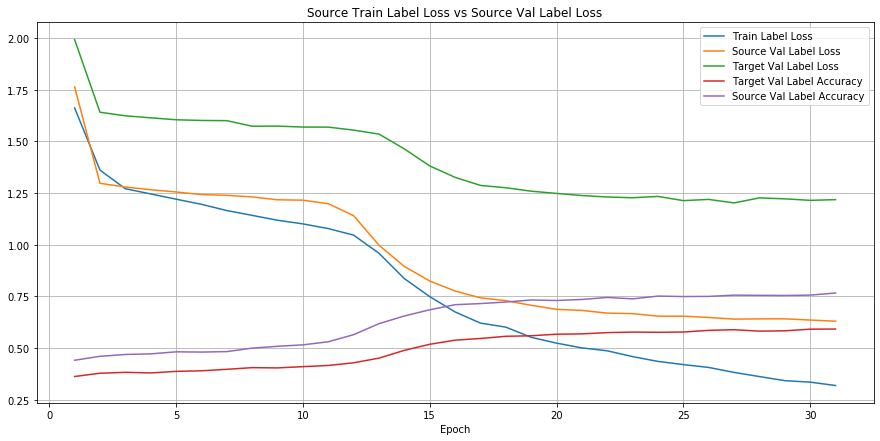

In [16]:
ax = get_loss_curve(experiment)
plt.show()

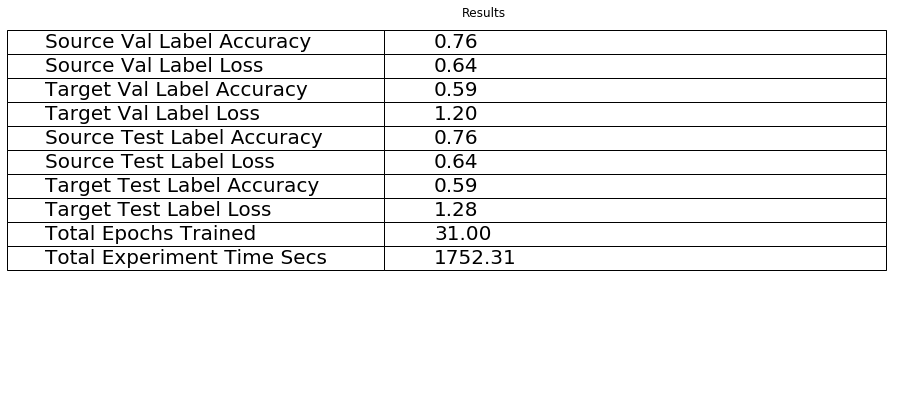

In [17]:
get_results_table(experiment)

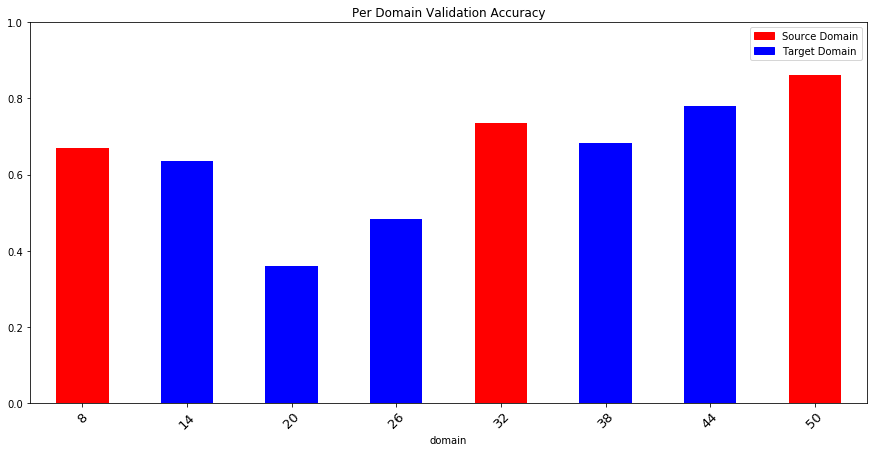

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7571180555555556 Target Test Label Accuracy: 0.58625
Source Val Label Accuracy: 0.7559027777777778 Target Val Label Accuracy: 0.5886458333333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "learningRate_oracle.run2", "parameters": {"experiment_name": "learningRate_oracle.run2", "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class":